# General nuclear segmentation training notebook

This notebook trains a model to perform nuclear segmentation of fluorescent microscopy images.

## Part 1: Import relevant python packages

This section imports python packages that are used throughout the notebook and defines parameters that can be used with papermill

In [1]:
import os
import errno

import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
        
import deepcell

In [2]:
# Define parameters that can be set with papermill
backbone = 'resnet50'
dataset_name='general_nuclear'
n_epochs = 8
date = '04242020'
dataset_fraction = .01
train_test_seed = 0
train_permutation_seed = 0
train_val_seed=314
model_type = 'watershed'
batch_size = 4 if model_type == 'retinamask' else 16

In [3]:
# Parameters
n_epochs = 16
batch_size = 16
date = "05062020"
filename = "nuclear_1_1_resnet50_watershed"
train_permutation_seed = 1
dataset_fraction = 1
backbone = "resnet50"
model_type = "watershed"


## Part 2: Load training data and create data generators

Data generators augment data and feed it into the model training process. Here, we define the generators that will be used to train our segmentation model.

In [4]:
from deepcell.utils.data_utils import get_data, reshape_movie
from deepcell import image_generators
from deepcell.utils import train_utils
from sklearn.model_selection import train_test_split
from deepcell_tracking.utils import load_trks

# Helper function - get unique tracks
def get_n_tracks(array):
    # array with dims (batch, time, x, y, c)
    n_tracks = 0
    for b in array:
        n_tracks += len(np.unique(b)) - 1
    return n_tracks

# Helper function - get unique cells
def get_n_cells(array):
    # array with dims (batch, time, x, y, c)
    n_cells = 0
    for b in array:
        for t in b:
            n_cells += len(np.unique(t)) - 1
    return n_cells

# Helper function - convert indices
def convert_indices(indices, X_list):
    N_batches = np.array([x.shape[0] for x in X_list])
    N_cumsum = np.cumsum(N_batches)
    converted_index = []
    for i in range(len(X_list)):
        if i==0:
            i_index = indices[indices < N_cumsum[i]]
            converted_index.append(i_index)
        else:
            i_index = indices[np.logical_and(indices < N_cumsum[i], indices >= N_cumsum[i-1])] - N_cumsum[i-1]
            converted_index.append(i_index)    
    return converted_index

# Helper function - reshape movies
def reshape_list_of_movies(X_list, y_list, reshape_size=128, crop=False):
    X_reshape = []
    y_reshape = []
    for Xl, yl in zip(X_list, y_list):
        Xr, yr = reshape_movie(Xl, yl, reshape_size=reshape_size)
        Xr = Xr.reshape((-1, reshape_size, reshape_size, Xr.shape[-1]))
        yr = yr.reshape((-1, reshape_size, reshape_size, yr.shape[-1]))
        X_reshape.append(Xr)
        y_reshape.append(yr)
    X_reshape = np.concatenate(X_reshape, axis=0)
    y_reshape = np.concatenate(y_reshape, axis=0)
    
    return X_reshape, y_reshape

# Load datasets 
dataset_direc = '/data/training_data/'

hela_filename = 'HeLa_S3.trks'
hek_filename = 'HEK293.trks'
nih_filename = '3T3_NIH.trks'
raw_filename = 'RAW2647.trks'

filenames = [hela_filename, hek_filename, nih_filename, raw_filename]

X_train = []
y_train = []

X_test = []
y_test = []

for filename in filenames:
    path = os.path.join(dataset_direc, filename)
    training_data = load_trks(path)
    X = training_data['X']
    y = training_data['y']
    
    print(X.shape, y.shape)
    
    # Split into training and testing dataset
    Xt, Xtest, yt, ytest = train_test_split(X, y, test_size=0.2, random_state=train_test_seed)
    
    # Crop test dataset
    X_test = [arr[:,:,0:128,0:128,:] for arr in X_test]
    y_test = [arr[:,:,0:128,0:128,:] for arr in y_test]
    
    X_train.append(Xt)
    y_train.append(yt)
    X_test.append(Xtest)
    y_test.append(ytest)
    
# Select subset of the training data
N_batches = sum([x.shape[0] for x in X_train])
index = np.arange(N_batches)
dataset_size = int(dataset_fraction * N_batches)
permuted_index = np.random.RandomState(seed=train_permutation_seed).permutation(index)
reduced_index = permuted_index[0:dataset_size]
converted_index = convert_indices(reduced_index, X_train)

X_reduced = [x[ci] for x, ci in zip(X_train, converted_index)]
y_reduced = [y[ci] for y, ci in zip(y_train, converted_index)]

# Split into training and validation datasets
N_batches = sum([x.shape[0] for x in X_reduced])
index = np.arange(N_batches)
val_size = int(0.2 * N_batches)
permuted_index = np.random.RandomState(seed=train_val_seed).permutation(index)
val_index = permuted_index[0:val_size]
train_index = permuted_index[val_size:]

val_ci = convert_indices(val_index, X_reduced)
train_ci = convert_indices(train_index, X_reduced)

X_train = [x[ci] for x, ci in zip(X_reduced, train_ci)]
y_train = [y[ci] for y, ci in zip(y_reduced, train_ci)]

X_val = [x[ci] for x, ci in zip(X_reduced, val_ci)]
y_val = [y[ci] for y, ci in zip(y_reduced, val_ci)]
    
# Record the number of tracks and cells
n_tracks_train = sum([get_n_tracks(y) for y in y_train])
n_tracks_val = sum([get_n_tracks(y) for y in y_val])
n_tracks_test = sum([get_n_tracks(y) for y in y_test])

n_cells_train = sum([get_n_cells(y) for y in y_train])
n_cells_val = sum([get_n_cells(y) for y in y_val])
n_cells_test = sum([get_n_cells(y) for y in y_test])
    
# Reshape the datasets
X_train, y_train = reshape_list_of_movies(X_train, y_train)
X_val, y_val = reshape_list_of_movies(X_val, y_val)
X_test, y_test = reshape_list_of_movies(X_test, y_test)

train_dict = {'X':X_train, 'y':y_train}
val_dict = {'X':X_val, 'y':y_val}
test_dict = {'X':X_test, 'y':y_test}

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print('Number of training tracks {}'.format(n_tracks_train))
print('Number of validation tracks {}'.format(n_tracks_val))
print('Number of testing tracks {}'.format(n_tracks_test))

print('Number of training cells {}'.format(n_cells_train))
print('Number of validation cells {}'.format(n_cells_val))
print('Number of testing cells {}'.format(n_cells_test))

(180, 40, 216, 256, 1) (180, 40, 216, 256, 1)
(259, 30, 135, 160, 1) (259, 30, 135, 160, 1)
(240, 30, 154, 182, 1) (240, 30, 154, 182, 1)
(124, 30, 202, 240, 1) (124, 30, 202, 240, 1)
Reshaped feature data from (127, 40, 216, 256, 1) to (508, 40, 128, 128, 1)
Reshaped training data from (127, 40, 216, 256, 1) to (508, 40, 128, 128, 1)
Reshaped feature data from (159, 30, 135, 160, 1) to (636, 30, 128, 128, 1)
Reshaped training data from (159, 30, 135, 160, 1) to (636, 30, 128, 128, 1)
Reshaped feature data from (151, 30, 154, 182, 1) to (604, 30, 128, 128, 1)
Reshaped training data from (151, 30, 154, 182, 1) to (604, 30, 128, 128, 1)
Reshaped feature data from (77, 30, 202, 240, 1) to (308, 30, 128, 128, 1)
Reshaped training data from (77, 30, 202, 240, 1) to (308, 30, 128, 128, 1)
Reshaped feature data from (17, 40, 216, 256, 1) to (68, 40, 128, 128, 1)
Reshaped training data from (17, 40, 216, 256, 1) to (68, 40, 128, 128, 1)
Reshaped feature data from (48, 30, 135, 160, 1) to (192,

In [5]:
from deepcell.utils.retinanet_anchor_utils import generate_anchor_params
from tensorflow.python.keras import backend as K

# Get anchor settings for RetinaMask models
pyramid_levels = ['P3', 'P4']
anchor_size_dict = {'P3':16, 'P4':32}
anchor_params = generate_anchor_params(pyramid_levels, anchor_size_dict)

# Data augmentation parameters
generator_kwargs = {}
generator_kwargs['rotation_range'] = 180
generator_kwargs['shear_range'] = 0
generator_kwargs['zoom_range'] = 0.25
generator_kwargs['horizontal_flip'] = True
generator_kwargs['vertical_flip'] = True

generator_val_kwargs = {}
generator_val_kwargs['rotation_range'] = 0
generator_val_kwargs['shear_range'] = 0
generator_val_kwargs['zoom_range'] = 0
generator_val_kwargs['horizontal_flip'] = False
generator_val_kwargs['vertical_flip'] = False

# Minimum number of objects in an image
min_objects = 3 if model_type == 'retinamask' else 0

# Random seed
seed=808

if model_type == 'watershed':
    datagen = image_generators.SemanticDataGenerator(**generator_kwargs)
    datagen_val = image_generators.SemanticDataGenerator(**generator_val_kwargs)
    
    train_data = datagen.flow(
        train_dict,
        seed=seed,
        transforms=['centroid', 'watershed-cont', 'fgbg'],
        transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'centroid': {'alpha':'auto', 'beta':0.5}},
        min_objects=min_objects,
        batch_size=batch_size)

    val_data = datagen_val.flow(
        val_dict,
        seed=seed,
        transforms=['centroid', 'watershed-cont', 'fgbg'],
        transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'centroid': {'alpha':'auto', 'beta':0.5}},
        min_objects=min_objects,
        batch_size=batch_size)
    
elif model_type == 'pixelwise':
    datagen = image_generators.SemanticDataGenerator(**generator_kwargs)
    datagen_val = image_generators.SemanticDataGenerator(**generator_val_kwargs)
    
    train_data = datagen.flow(
        train_dict,
        seed=seed,
        transforms=['pixelwise'],
        transforms_kwargs={},
        min_objects=min_objects,
        batch_size=batch_size)

    val_data = datagen_val.flow(
        val_dict,
        seed=seed,
        transforms=['pixelwise'],
        transforms_kwargs={},
        min_objects=min_objects,
        batch_size=batch_size)

elif model_type == 'retinamask':
    datagen = image_generators.RetinaNetGenerator(**generator_kwargs)
    datagen_val = image_generators.RetinaNetGenerator(**generator_val_kwargs)
    
    train_data = datagen.flow(
        train_dict=train_dict,
        seed=seed,
        transforms=[],
        transforms_kwargs={},
        min_objects=min_objects,
        batch_size=batch_size,
        anchor_params=anchor_params,
        pyramid_levels=pyramid_levels,
        include_masks=True)
    
    val_data = datagen_val.flow(
        train_dict=val_dict,
        seed=seed,
        transforms=[],
        transforms_kwargs={},
        min_objects=min_objects,
        batch_size=batch_size,
        anchor_params=anchor_params,
        pyramid_levels=pyramid_levels,
        include_masks=True)
    

## Part 3: Define model

Here we define a PanopticNet to perform the image segmentation. This model will predict the inner distance and outer distance transform (as done in ), as well as the foreground-background transform.

In [6]:
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell.model_zoo.retinamask import RetinaMask
from deepcell import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.losses import MSE

# Define optimizer
optimizer = Adam(lr=1e-4, clipnorm=0.001)
    
if model_type == 'watershed':
    model = PanopticNet(backbone,
                       input_shape=train_data.x.shape[1:],
                       norm_method='whole_image',
                       num_semantic_heads=3,
                       num_semantic_classes=[1,1,2],
                       location=True,
                       include_top=True,
                       use_imagenet=False,
                       interpolation='bilinear',
                       lite=True)

    # Define loss
    loss_layers = ['semantic_0', 'semantic_1', 'semantic_2']
    loss = {}

    for layer_name in loss_layers:
        n_classes = model.get_layer(layer_name).output_shape[-1]
        if n_classes > 1:
            def loss_function(y_true, y_pred):
                return 0.01 * losses.weighted_categorical_crossentropy(
                    y_true, y_pred, n_classes=n_classes)
            loss[layer_name] = loss_function
        elif n_classes == 1:
            loss[layer_name] = MSE

    # Compile model
    model.compile(loss=loss, optimizer=optimizer)
    
elif model_type == 'pixelwise':
    model = PanopticNet(backbone,
                       input_shape=train_data.x.shape[1:],
                       norm_method='whole_image',
                       num_semantic_heads=1,
                       num_semantic_classes=[3],
                       use_imagenet=False,
                       location=False,
                       include_top=True)

    # Define loss
    loss = {}
    
    def loss_function(y_true, y_pred):
        return losses.weighted_categorical_crossentropy(
                    y_true, y_pred, n_classes=3)
    
    loss['semantic_0'] = loss_function
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer)
    
elif model_type == 'retinamask':
    model = RetinaMask(backbone,
                      num_classes=1,
                      input_shape=train_data.x.shape[1:],
                      norm_method='whole_image',
                      use_imagenet=False,
                      pyramid_levels=pyramid_levels,
                      anchor_params=anchor_params)
    
    # Define loss
    retinanet_losses = losses.RetinaNetLosses()
    loss = {
        'regression': retinanet_losses.regress_loss,
        'classification': retinanet_losses.classification_loss,
        'masks': retinanet_losses.mask_loss
    }
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer)
    
model.summary()

W0524 16:56:57.450002 140247178372928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "panopticnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
norm (ImageNormalization2D)     (None, 128, 128, 1)  0           input_0[0][0]                    
__________________________________________________________________________________________________
location (Location2D)           (None, 128, 128, 2)  0           norm[0][0]                       
__________________________________________________________________________________________________
concatenate_location (Concatena (None, 128, 128, 3)  0           norm[0][0]                       
                                                                 location[0][0]         

## Part 4: Define model training parameters

Here, we define all of the parameters needed for training. The model trainer objects will record these metadata after training.

In [7]:
model_name = 'nuclear_{}_{}_{}_{}'.format(str(train_permutation_seed), dataset_fraction, backbone, model_type)
model_path = os.path.join('/data', 'models', date, model_name)
dataset_metadata={'name': dataset_name,
                  'other': 'Pooled nuclear data from HEK293, HeLa-S3, NIH-3T3, and RAW264.7 cells.'}
training_kwargs = {}
training_kwargs['batch_size'] = batch_size
training_kwargs['lr'] = 1e-5 if model_type=='retinamask' else 1e-4
training_kwargs['lr_decay'] = 0.95
training_kwargs['training_seed'] = 0
training_kwargs['n_epochs'] = n_epochs
training_kwargs['training_steps_per_epoch'] = 82800//16 if model_type == 'retinamask' else 82800 // training_kwargs['batch_size']
training_kwargs['validation_steps_per_epoch'] = val_data.y.shape[0] // training_kwargs['batch_size']

## Part 5: Create the model trainer and train the model

Here, we create the model trainer, train the model, and export the model - along with the metadata and benchmarks

In [8]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import json
import hashlib
import numpy as np

from skimage.morphology import remove_small_objects

from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler, get_callbacks
from deepcell.metrics import Metrics

from tensorflow.python.compiler.tensorrt import trt_convert as trt

class ModelTrainer(object):
    def __init__(self, 
                model,
                model_name,
                model_path,
                train_generator,
                validation_generator,
                benchmarking_data=None,
                log_dir=None,
                tfserving_path=None,
                training_callbacks='default',
                max_batch_size=256,
                export_precisions = ['fp16'],
                postprocessing_fn=None,
                postprocessing_kwargs={},
                predict_batch_size=4,
                model_version=0,
                min_size=100,
                dataset_metadata={},
                training_kwargs={}):
    
        """
        Model trainer class for segmentation models. This class eases model development by
        linking relevant metadata (dataset, training parameters, benchmarking) to the model
        training process.
        """

        # Add model information
        self.model = model
        self.model_name = model_name
        self.model_path = model_path
        self.model_version = model_version

        # Add dataset information
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.benchmarking_data = benchmarking_data
        self.dataset_metadata = dataset_metadata
        self.postprocessing_fn = postprocessing_fn
        self.postprocessing_kwargs = postprocessing_kwargs
        self.predict_batch_size = predict_batch_size

        # Add benchmarking information
        self.min_size = min_size

        # Add export information
        self.max_batch_size = max_batch_size
        self.export_precisions = export_precisions

        # Add directories for logging and model export
        if log_dir is None:
            self.log_dir = os.path.join(model_path, 'logging')
        else:
            self.log_dir = log_dir
        
        if tfserving_path is None:
            self.tfserving_path = os.path.join(model_path, 'serving')
        else:
            self.tfserving_path = tfserving_path

        # Add training kwargs
        self.batch_size = training_kwargs.pop('batch_size', 1)
        self.training_steps_per_epoch = training_kwargs.pop('training_steps_per_epoch', 
                                                self.train_generator.y.shape[0] // self.batch_size)
        self.validation_steps_per_epoch = training_kwargs.pop('validation_steps_per_epoch', 
                                                self.validation_generator.y.shape[0] // self.batch_size)
        self.n_epochs = training_kwargs.pop('n_epochs', 8)
        self.lr = training_kwargs.pop('lr', 1e-5)
        self.lr_decay = training_kwargs.pop('lr_decay', 0.95)
        self.lr_sched = training_kwargs.pop('lr_sched', rate_scheduler(lr=self.lr, decay=self.lr_decay))

        # Add callbacks
        if training_callbacks == 'default':
            model_name = os.path.join(model_path, model_name + '.h5')
            self.training_callbacks = get_callbacks(model_name, lr_sched=self.lr_sched,
                                        tensorboard_log_dir=self.log_dir,
                                        save_weights_only=False,
                                        monitor='val_loss', verbose=1)
        else:
            self.training_callbacks = training_callbacks

        self.trained = False

        return None

    def _create_hash(self):
        if not self.trained:
            raise ValueError('Can only create a hash for a trained model')
        else:
            weights = []
            for layer in self.model.layers:
                weights += layer.get_weights()
            summed_weights_list = [np.sum(w) for w in weights]
            summed_weights = sum(summed_weights_list)
            model_hash = hashlib.md5(str(summed_weights).encode())
            self.model_hash = model_hash.hexdigest()

    def _fit(self):
        loss_history = self.model.fit_generator(
        self.train_generator,
        steps_per_epoch=self.training_steps_per_epoch,
        epochs=self.n_epochs,
        validation_data=self.validation_generator,
        validation_steps=self.validation_steps_per_epoch,
        callbacks=self.training_callbacks,
        verbose=2)

        self.trained = True
        self.loss_history = loss_history

        return None

    def _benchmark(self):
        if not self.trained:
            raise ValueError('Model training is not complete')
        else:
            if self.benchmarking_data is None:
                x = self.validation_generator.x.copy()
                y_true = self.validation_generator.y.copy()
            else:
                x = self.benchmarking_data['X']
                y_true = self.benchmarking_data['y']

            outputs = self.model.predict(x, batch_size=self.predict_batch_size)
            y_pred = self.postprocessing_fn(outputs, **self.postprocessing_kwargs)

            if len(y_pred.shape) == 3:
                y_pred = np.expand_dims(y_pred, axis=-1)    #TODO: This is a hack because the postprocessing fn returns
                                                            #masks with no channel dimensions. This should be fixed.
            
            benchmarks = Metrics(self.model_name, seg=False)
            benchmarks.calc_object_stats(y_true, y_pred)

            # Save benchmarks in dict
            self.benchmarks = {}
            for key in benchmarks.stats.keys():
                self.benchmarks[key] = int(benchmarks.stats[key].sum())

            for i in range(y_pred.shape[0]):
                y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=self.min_size)
                y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=self.min_size)

            benchmarks = Metrics(self.model_name + ' - Removed objects less than {} pixels'.format(self.min_size), 
                                    seg=False)
            benchmarks.calc_object_stats(y_true, y_pred)

            # Save benchmarks in dict
            self.benchmarks_remove_small_objects = {}
            for key in benchmarks.stats.keys():
                self.benchmarks_remove_small_objects[key] = int(benchmarks.stats[key].sum())

        return None

    def _create_training_metadata(self):
        training_metadata = {}
        training_metadata['batch_size'] = self.batch_size
        training_metadata['lr'] = self.lr
        training_metadata['lr_decay'] = self.lr_decay
        training_metadata['n_epochs'] = self.n_epochs
        training_metadata['training_steps_per_epoch'] = self.training_steps_per_epoch
        training_metadata['validation_steps_per_epoch'] = self.validation_steps_per_epoch

        self.training_metadata = training_metadata

        return None

    def _export_tf_serving(self):
        export_model(self.model, self.tfserving_path, model_version=self.model_version)

        # Convert model to TensorRT with float16
        if 'fp16' in self.export_precisions:
            export_model_dir = os.path.join(self.tfserving_path, str(self.model_version))
            export_model_dir_fp16 = os.path.join(self.tfserving_path + '_fp16', str(self.model_version))

            converter = trt.TrtGraphConverter(input_saved_model_dir=export_model_dir,
                                            max_batch_size=self.max_batch_size,
                                            precision_mode='fp16')
            converter.convert()
            converter.save(export_model_dir_fp16)

        return None

    def create_model(self, export_serving=False, export_lite=False):

        # Train model
        self._fit()

        # Load best performing weights
        model_name = os.path.join(self.model_path, self.model_name + '.h5')
        self.model.load_weights(model_name)

        # Create model hash
        self._create_hash()

        # Create benchmarks
        self._benchmark()

        # Create model metadata
        self._create_training_metadata()

        # Save model
        model_name = os.path.join(self.model_path, self.model_name + '_' + self.model_hash + '.h5')
        self.model.save(model_name)

        # Save loss history
        loss_name = os.path.join(self.model_path, self.model_name + '_loss_' + self.model_hash + '.npz')
        np.savez(loss_name, loss_history=self.loss_history.history)

        # Save metadata (training and dataset) and benchmarks
        metadata = {}
        metadata['model_hash'] = self.model_hash
        metadata['training_metadata'] = self.training_metadata
        metadata['dataset_metadata'] = self.dataset_metadata
        metadata['benchmarks'] = self.benchmarks
        metadata['benchmarks_remove_small_objects'] = self.benchmarks_remove_small_objects

        # TODO: Saving the benchmarking object in this way saves each individual benchmark.
        # This should be refactored to save the sums.

        metadata_name = os.path.join(self.model_path, self.model_name + '_' + self.model_hash + '.json')
        
        with open(metadata_name, 'w') as json_file:
            json.dump(metadata, json_file)

        # Export tf serving model
        if export_serving:
            self._export_tf_serving()

        return None

In [9]:
from deepcell_toolbox import retinamask_postprocess
from deepcell_toolbox.deep_watershed import deep_watershed as watershed_postprocess 
from functools import partial
from scipy import ndimage

if model_type == 'watershed':
    postprocessing_fn = watershed_postprocess
elif model_type == 'pixelwise':
    def pixelwise(prediction, threshold=.5):
        """Post-processing for pixelwise transform predictions.
        Uses the interior predictions to uniquely label every instance.
        Args:
            prediction: pixelwise transform prediction
            threshold: confidence threshold for interior predictions
        Returns:
            post-processed data with each cell uniquely annotated
        """
        labeled = []
        for b in range(prediction.shape[0]):
            pred = prediction[b]
            interior = pred[..., 1] > threshold
            data = np.expand_dims(interior, axis=-1)
            label_image = ndimage.label(data)[0]
            labeled.append(label_image)
        labeled = np.stack(labeled, axis=0)
        return labeled
    postprocessing_fn = pixelwise
elif model_type == 'retinamask':
    postprocessing_fn = partial(retinamask_postprocess, image_shape=(128,128))
    
model_trainer = ModelTrainer(model,
                            model_name,
                            model_path,
                            train_data,
                            val_data,
                            benchmarking_data = test_dict,
                            postprocessing_fn=postprocessing_fn,
                            predict_batch_size=32,
                            dataset_metadata=dataset_metadata,
                            training_kwargs=training_kwargs)

model_trainer.create_model()

Epoch 1/16


W0507 05:10:10.874615 140442475734848 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0507 05:10:39.293293 140442475734848 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.223546). Check your callbacks.



Epoch 00001: val_loss improved from inf to 0.00643, saving model to /data/models/05062020/nuclear_1_1_resnet50_watershed/nuclear_1_1_resnet50_watershed.h5
5175/5175 - 1131s - loss: 0.0161 - semantic_0_loss: 0.0101 - semantic_1_loss: 0.0050 - semantic_2_loss: 9.5829e-04 - val_loss: 0.0064 - val_semantic_0_loss: 0.0030 - val_semantic_1_loss: 0.0028 - val_semantic_2_loss: 6.4151e-04
Epoch 2/16

Epoch 00002: val_loss improved from 0.00643 to 0.00606, saving model to /data/models/05062020/nuclear_1_1_resnet50_watershed/nuclear_1_1_resnet50_watershed.h5
5175/5175 - 1074s - loss: 0.0067 - semantic_0_loss: 0.0028 - semantic_1_loss: 0.0032 - semantic_2_loss: 7.1912e-04 - val_loss: 0.0061 - val_semantic_0_loss: 0.0028 - val_semantic_1_loss: 0.0026 - val_semantic_2_loss: 5.9307e-04
Epoch 3/16

Epoch 00003: val_loss improved from 0.00606 to 0.00582, saving model to /data/models/05062020/nuclear_1_1_resnet50_watershed/nuclear_1_1_resnet50_watershed.h5
5175/5175 - 1072s - loss: 0.0060 - semantic_0_

W0507 09:55:42.412848 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:111: RuntimeWarning: invalid value encountered in long_scalars
  dice = (2 * intersection.sum() / (pred.sum() + truth.sum()))
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:112: RuntimeWarning: invalid value encountered in long_scalars
  jaccard = intersection.sum() / union.sum()
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:113: RuntimeWarning: invalid value encountered in long_scalars
  precision = intersection.sum() / pred.sum()
/usr/local/lib/python3.6/dist-packages/deepcell/metrics.py:114: RuntimeWarning: invalid value encountered in long_scalars
  recall = intersection.sum() / truth.sum()
W0507 09:55:42.453919 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:42.468810 140442475734848 metrics.py:103] DI

W0507 09:55:46.386941 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:46.408948 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:46.446724 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:46.460546 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:46.474449 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:46.488907 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:46.502847 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:46.516743 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:55:54.350601 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:54.363071 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:54.375436 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:54.388114 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:54.404618 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:54.417141 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:54.429749 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:54.442293 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:55:56.018314 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:56.030879 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:56.043529 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:56.056160 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:56.068688 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:56.081319 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:56.093966 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:56.106654 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:55:57.045361 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:57.058144 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:57.070742 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:57.083384 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:57.096161 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:57.109196 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:57.121905 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:55:57.134706 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:57:21.733603 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:21.746063 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:21.758511 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:21.771023 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:21.783551 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:21.796297 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:21.831242 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:21.844139 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:57:31.121800 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:31.134986 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:31.148012 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:31.161027 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:31.174090 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:31.187235 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:31.200312 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:31.213489 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:57:34.225807 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:34.240053 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:34.254185 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:34.266834 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:34.279642 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:34.292591 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:34.305521 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:34.318508 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:57:39.030444 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:39.043294 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:39.056211 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:39.069096 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:39.081993 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:39.094856 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:39.107728 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:39.120625 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti


____________Object-based statistics____________

Number of true cells:		 47124
Number of predicted cells:	 46108

Correct detections:  41277	Recall: 87.5923096511331777946907095611095428466796875%
Incorrect detections: 4831	Precision: 89.5224256094387129678580095060169696807861328125%

Gained detections: 4432	Perc Error: 44.19625049860390930689391097985208034515380859375%
Missed detections: 5287	Perc Error: 52.72237734343837445294411736540496349334716796875%
Merges: 221		Perc Error: 2.20382927802153982810295929084531962871551513671875%
Splits: 79		Perc Error: 0.78779417630634218649987587923533283174037933349609375%
Catastrophes: 9		Perc Error: 0.08974870362983645988297354278984130360186100006103515625%

Gained detections from splits: 80
Missed detections from merges: 241
True detections involved in catastrophes: 19
Predicted detections involved in catastrophes: 19 

Average Pixel IOU (Jaccard Index): 0.824459574259250427274992034654133021831512451171875 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:158: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
W0507 09:57:59.278581 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:59.291386 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:59.304195 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:59.316959 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:59.329844 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:57:5

W0507 09:58:02.694028 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:02.706832 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:02.719460 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:02.732094 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:02.744915 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:02.757952 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:02.777009 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:02.791496 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:58:09.533196 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:09.546447 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:09.559566 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:09.572385 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:10.256173 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:10.268946 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:10.281668 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:10.294507 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:58:11.789046 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:11.803221 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:11.817092 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:11.830449 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:11.843055 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:11.855529 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:11.867918 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:11.880259 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:58:12.609640 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:12.622484 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:12.635173 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:12.647829 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:12.662625 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:12.677087 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:12.689772 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:12.702444 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:58:17.723261 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:17.736465 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:17.749009 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:17.761552 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:17.774121 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:17.786670 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:17.799149 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:58:17.811220 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:59:27.449594 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:27.462674 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:27.475713 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:27.488659 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:27.501569 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:27.514425 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:27.527470 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:27.540304 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:59:35.691779 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:35.704510 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:35.717364 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:35.730652 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:35.743916 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:35.756749 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:35.769643 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:35.783154 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:59:38.516101 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:38.528811 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:38.541462 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:38.554144 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:38.567167 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:39.305610 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:39.318072 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:39.330590 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:59:42.181401 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:42.195822 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:42.210237 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:42.224597 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:42.239025 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:42.253314 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:42.267564 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:42.281729 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti

W0507 09:59:45.451447 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:45.464231 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:45.477144 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:45.490339 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:45.503446 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:45.515994 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:45.528551 140442475734848 metrics.py:103] DICE score is technically 1.0, but prediction and truth arrays are empty. 
W0507 09:59:45.541178 140442475734848 metrics.py:103] DICE score is technically 1.0, but predicti


____________Object-based statistics____________

Number of true cells:		 39608
Number of predicted cells:	 38661

Correct detections:  37297	Recall: 94.16532013734598649534746073186397552490234375%
Incorrect detections: 1364	Precision: 96.4718967434882728184675215743482112884521484375%

Gained detections: 1083	Perc Error: 33.40530536705737318925457657314836978912353515625%
Missed detections: 1948	Perc Error: 60.08636644046884356384907732717692852020263671875%
Merges: 143		Perc Error: 4.41085749537322602265021487255580723285675048828125%
Splits: 61		Perc Error: 1.8815545959284392107946359828929416835308074951171875%
Catastrophes: 7		Perc Error: 0.2159161011721159872944753033152665011584758758544921875%

Gained detections from splits: 62
Missed detections from merges: 145
True detections involved in catastrophes: 14
Predicted detections involved in catastrophes: 15 

Average Pixel IOU (Jaccard Index): 0.8252134816714107312662918047863058745861053466796875 



# Predict

In [11]:
pred_model = model
pred_model_name = os.path.join(model_path, model_name + '.h5')
pred_model.load_weights(pred_model_name)

In [43]:
from deepcell_toolbox.deep_watershed import deep_watershed as watershed_postprocess 

outputs = pred_model.predict(test_dict['X'], batch_size=32)
y_pred = watershed_postprocess(outputs)

In [44]:
from skimage.morphology import remove_small_objects

y_true = test_dict['y']

if len(y_pred.shape) == 3:
    y_pred = np.expand_dims(y_pred, axis=-1)

for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=100)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  # Remove the CWD from sys.path while we load stuff.


Image number: 3298


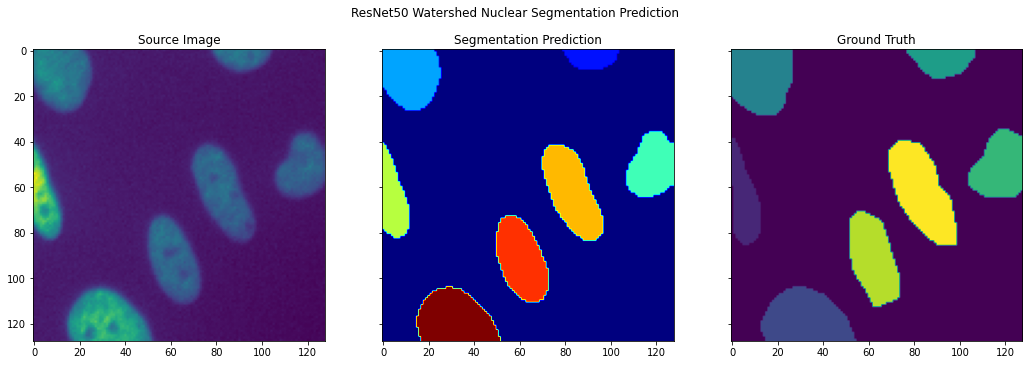

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

index = 3298 # np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(y_pred[index, ..., 0], cmap='jet')
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(y_true[index, ..., 0])
ax[2].set_title('Ground Truth')

plt.suptitle('ResNet50 Watershed Nuclear Segmentation Prediction')

fig.tight_layout(rect=[0, 0.01, 1, 0.9])
plt.show()
plt.savefig('nuclear_1_1_resnet50_watershed_pred_nuclear.pdf')

In [33]:
(X_train_C, y_train_C), (X_test_C, y_test_C) = deepcell.datasets.cytoplasm.hela_s3.load_data(seed=0)

632602624/632595468 [==============================] - 9s 0us/step


In [46]:
# Crop
X_test_C = X_test_C[:, :128, :128, :]
y_test_C = y_test_C[:, :128, :128, :]

In [47]:
outputs = pred_model.predict(X_test_C, batch_size=32)
y_pred = watershed_postprocess(outputs)
y_true = y_test_C

if len(y_pred.shape) == 3:
    y_pred = np.expand_dims(y_pred, axis=-1)

for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=100)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  # Remove the CWD from sys.path while we load stuff.


Image number: 120


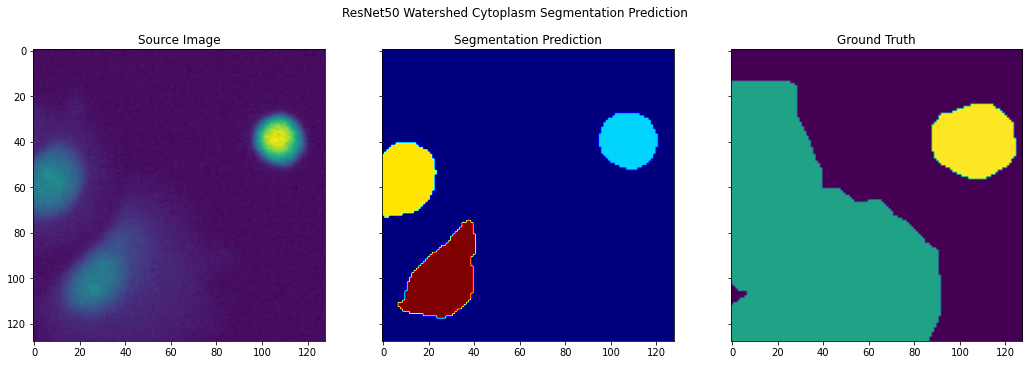

<Figure size 432x288 with 0 Axes>

In [99]:
import matplotlib.pyplot as plt

index = 120 #np.random.randint(low=0, high=X_test_C.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test_C[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(y_pred[index, ..., 0], cmap='jet')
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(y_true[index, ..., 0])
ax[2].set_title('Ground Truth')

plt.suptitle('ResNet50 Watershed Cytoplasm Segmentation Prediction')

fig.tight_layout(rect=[0, 0.01, 1, 0.9])
plt.show()
plt.savefig('nuclear_1_1_resnet50_watershed_pred_cytoplasm.pdf')